In [1]:
import matplotlib.pyplot as plt
import numpy as np
#need at least 1.16.0 version of numpy

file='redblue_200.txt'
data=np.loadtxt(file,skiprows=1,dtype='i8')
dscrp=np.loadtxt(file,max_rows=1,dtype='i8')
print(dscrp)

[100 100 273]


In [2]:
#SI1
#determinant test; return 1 if r is left of line pq, -1 if r right of line pq, 0 if on line pq
def detTest(px,py,qx,qy,rx,ry):
    D=np.array([[1,px,py],[1,qx,qy],[1,rx,ry]],dtype='i8')
    return int(np.sign(np.linalg.det(D)))
    
#returns true iff pq and rs cross
def cross(px,py,qx,qy,rx,ry,sx,sy):
    pqr=detTest(px,py,qx,qy,rx,ry)
    pqs=detTest(px,py,qx,qy,sx,sy)
    if not ((pqr==1 and pqs==-1) or (pqr==-1 and pqs==1)):
        return False
    rsp=detTest(rx,ry,sx,sy,px,py)
    rsq=detTest(rx,ry,sx,sy,qx,qy)
    if not ((rsp==1 and rsq==-1) or (rsp==-1 and rsq==1)):
        return False
    #plt.plot([px,qx],[py,qy])
    #plt.plot([rx,sx],[ry,sy])
    #plt.show()
    return True

In [3]:
#brute force test to see if description in the 
#first line matches the number of crossings in the data
def BFsmao(dscrp,data):
    crossing=0
    red=data[:dscrp[0]]
    blue=data[dscrp[0]:]
    for i in range(len(red)):
        for j in range(len(blue)):
            if cross(red[i][0],red[i][1],red[i][2],red[i][3],blue[j][0],blue[j][1],blue[j][2],blue[j][3]):
                crossing+=1
    if crossing==dscrp[2]:
        print('VERIFIED')
    else:
        print(crossing)
        
BFsmao(dscrp,data)

VERIFIED


In [4]:
#SI2
#classes for points and segments
class Point:
    def __init__(self, x, y):
        self.x=x
        self.y=y
        
    def cmp(self,pointB):
        if self.x==pointB.x and self.y==pointB.y:
            return 0
        elif self.x<pointB.x:
            return -1
        elif self.x==pointB.x and self.y<pointB.y:
            return -1
        else:
            return 1
    def plot(self):
        plt.scatter(self.x,self.y)
        
class Segment:
    def __init__(self,pointA,pointB,color):
        if pointA.cmp(pointB)==-1:
            self.p=pointA
            self.q=pointB
        else:
            self.p=pointB
            self.q=pointA
        self.color=color

    def cmp(self,pointC):
        return detTest(self.p.x,self.p.y,self.q.x,self.q.y,pointC.x,pointC.y)
    
    def cross(self,segB):
        return cross(self.p.x,self.p.y,self.q.x,self.q.y,segB.p.x,segB.p.y,segB.q.x,segB.q.y)
    
    def same(self,seg):
        if self.p.cmp(seg.p)==0 and self.q.cmp(seg.q)==0 and self.color==seg.color:
            return True
        else:
            return False
    def col(self,seg):
        if self.cmp(seg.p)==0 and self.cmp(seg.q)==0:
            return True
        else:
            return False
    
    def slope(self):
        if (self.q.x-self.p.x)==0:
            return float('inf')
        else:
            return (self.q.y-self.p.y)/(self.q.x-self.p.x)
    def plot(self):
        a=[self.p.x,self.q.x]
        b=[self.p.y,self.q.y]
        plt.plot(a,b)

In [5]:
#SI3
#flags are made from a segment and a endpoint of the segment
class Flag:
    def __init__(self, segment, endpoint):
        self.seg=segment
        self.pt=endpoint
        if (self.pt.cmp(self.seg.p)==0):
            self.type="start"
        elif (self.pt.cmp(self.seg.q)==0):
            self.type="term"
        else:
            raise NameError('point is not an endpoint of segment')
        
    def cmp(self, flagB):
        if self.pt.cmp(flagB.pt)==-1:
            return -1
        elif self.pt.cmp(flagB.pt)==1:
            return 1
        else:
            if self.type=="term" and flagB.type=="start":
                return -1
            elif self.type=="start" and flagB.type=="term":
                return 1
            else:
                if self.seg.slope()<flagB.seg.slope():
                    return -1
                elif self.seg.slope()>flagB.seg.slope():
                    return 1
                else:
                    if self.type=='term':
                        if self.seg.color=='red' and flagB.seg.color=='blue':
                            return -1
                        elif self.seg.color=='blue' and flagB.seg.color=='red':
                            return 1
                        else:
                            raise NameError('overlapping lines of same color')
                    else:
                        if self.seg.color=='blue' and flagB.seg.color=='red':
                            return -1
                        elif self.seg.color=='red' and flagB.seg.color=='blue':
                            return 1
                        else:
                            raise NameError('overlapping lines of same color')  

In [6]:
#SI3
#quicksort for flags
#adapted from: www.geeksforgeeks.org/python-program-for-quicksort/
def partition(arr,low,high): 
    i = ( low-1 )         
    pivot = arr[high]      
    for j in range(low , high):      
        if   arr[j].cmp(pivot)<=0:             
            i = i+1 
            arr[i],arr[j] = arr[j],arr[i] 
    arr[i+1],arr[high] = arr[high],arr[i+1] 
    return ( i+1 ) 

def quickSort(arr,low,high): 
    if low < high: 
        pi = partition(arr,low,high) 
        quickSort(arr, low, pi-1) 
        quickSort(arr, pi+1, high)
        
def sort(arr):
    quickSort(arr,0,len(arr)-1)

In [7]:
#SI3
#putting all the data into flags and sorting them

#make flags from array of values
def makeFlagsRaw(data):
    flags=[]
    for i in range(len(data)):
        p=Point(data[i][0],data[i][1])
        q=Point(data[i][2],data[i][3])
        if i<dscrp[0]:
            pq=Segment(p,q,'red')
        else:
            pq=Segment(p,q,'blue')
        flags.append(Flag(pq,p))
        flags.append(Flag(pq,q))
    return flags

#make flags array of segments
def makeFlags(segs):
    flags=[]
    for i in range(len(segs)):
        flags.append(Flag(segs[i],segs[i].p))
        flags.append(Flag(segs[i],segs[i].q))
    return flags

flags=makeFlagsRaw(data)
sort(flags)

In [8]:
#SI4,SI5
from collections import deque

#sweeps a sorted flags array and see if the red/blue segments cross, produces error if crosses
#keeps a list of broken red/blue segments, can turn it into flags
def checkNoCross(flags,color):
    s=Sweep1(flags,color)
    s.sweep()
    return s.brokenSegFlags()


class Sweep1():
    def __init__(self,flags,color):
        self.flags=deque(flags)
        self.active=[Segment(Point(-2**20,-2**20),Point(2**20,-2**20),color),Segment(Point(-2**20,2**20),Point(2**20,2**20),color)]
        self.color=color
        self.brokenSegs=[]
        
    def insert(self,index,seg):
        if self.active[index-1].cross(seg):
            raise NameError('intersection detected')
        if self.active[index].cross(seg):
            raise NameError('intersection detected')
        self.active.insert(index,seg)
    def remove(self,index):
        if self.active[index-1].cross(self.active[index+1]):
            raise NameError('intersection detected')
        del self.active[index]
        
    def nextEvent(self):
        event=self.flags.popleft()
        if event.type=='start':
            if event.seg.color==self.color:
                for i in range(len(self.active)-1):
                    if self.active[i].cmp(event.pt)==1 and self.active[i+1].cmp(event.pt)==-1:
                        self.insert(i+1,event.seg)
                        self.brokenSegs.append(event.seg)  #adding to segments
                        break
                    elif self.active[i].cmp(event.pt)==0:
                        raise NameError('intersection detected')
            if event.seg.color!=self.color:
                for i in range(len(self.active)-1):
                    if self.active[i].cmp(event.pt)==0:
                        segStart=self.active[i].p
                        segEnd=self.active[i].q
                        segColor=self.active[i].color
                        for j in range(len(self.brokenSegs)):  #removing the unseparated segment
                            if self.brokenSegs[j].same(self.active[i]):
                                del self.brokenSegs[j]
                                break
                        self.brokenSegs.append(Segment(segStart,event.pt,segColor))  #adding back the broken segments
                        self.brokenSegs.append(Segment(event.pt,segEnd,segColor))
                        
                        self.remove(i)
                        self.insert(i,Segment(event.pt,segEnd,segColor))
                        break
        elif event.type=='term' and event.seg.color==self.color:
            for i in range(len(self.active)):
                if self.active[i].col(event.seg):
                    self.remove(i)
                    break
    
    def sweep(self):
        while len(self.flags)>0:
            self.nextEvent()
        
    def brokenSegFlags(self):
        return makeFlags(self.brokenSegs)
    


In [9]:
red=checkNoCross(flags,'red')
blue=checkNoCross(flags,'blue')
newFlags=red+blue
sort(newFlags)

In [10]:
#SI6
#for a sorted list of flags, produces the above/below segments in order of the flags
def aboveBelowSegs(flags):
    s=Sweep2(flags)
    return s.sweep()


class Sweep2():
    def __init__(self,flags):
        self.flags=deque(flags)
        self.aRed=[Segment(Point(-2**20,-2**20),Point(2**20,-2**20),'red'),Segment(Point(-2**20,2**20),Point(2**20,2**20),'red')]
        self.aBlue=[Segment(Point(-2**20,-2**20),Point(2**20,-2**20),'blue'),Segment(Point(-2**20,2**20),Point(2**20,2**20),'blue')]
        self.aboveBelow=[]
        self.abAll=[]
        
    def same(self, event, segs):
        if event.type=='start':
            for i in range(len(segs)-1):
                if segs[i].cmp(event.pt)>=0 and segs[i+1].cmp(event.pt)==-1:
                    self.aboveBelow.append(i)
                    self.aboveBelow.append(i+1)
                    segs.insert(i+1,event.seg)
                    break
        if event.type=='term':
            for i in range(len(segs)):
                if segs[i].same(event.seg):
                    self.aboveBelow.append(i)
                    self.aboveBelow.append(i)
                    del segs[i]
                    break

    def opposite(self, event, segs):
        for i in range(len(segs)-1):
            if segs[i].cmp(event.pt)>=0 and segs[i+1].cmp(event.pt)==-1:
                self.aboveBelow.append(i)
                self.aboveBelow.append(i+1)
                break
            elif segs[i].cmp(event.pt)==0 and segs[i].slope()==event.seg.slope():
                self.aboveBelow.append(i)
                self.aboveBelow.append(i)
                break
                
    def nextEvent(self):
        event=self.flags.popleft()
        self.aboveBelow=[]
        if event.seg.color=='red':
            self.same(event,self.aRed)
            self.opposite(event,self.aBlue)
            self.abAll.append(self.aboveBelow)
        else:
            self.same(event,self.aBlue)
            self.opposite(event,self.aRed)
            self.abAll.append(self.aboveBelow)
            
    def sweep(self):
        while len(self.flags)>0:
            self.nextEvent()
        return self.abAll

In [11]:
abSegs=aboveBelowSegs(newFlags)

In [12]:
#some issues with split function

def findCrossings(newFlags,abSegs):
    s=Sweep3(newFlags,abSegs)
    return s.sweep()

class Sweep3():
    def __init__(self,newFlags,abSegs):
        self.flags=deque(newFlags)
        self.ab=deque(abSegs)
        #array of arrays of segments of same color. Bundles
        self.active=[[Segment(Point(-2**20,-2**20),Point(2**20,-2**20),'blue')],[Segment(Point(-2**20,-2**20),Point(2**20,-2**20),'red')],[Segment(Point(-2**20,2**20),Point(2**20,2**20),'blue')],[Segment(Point(-2**20,2**20),Point(2**20,2**20),'red')]]
        self.crossings=[]
    
    #merge the ith and i+1th bundle
    def merge(self,i):
        self.active[i]=self.active[i]+self.active[i+1]
        del self.active[i+1]
    
    #split the ith bundle at jth position with jth included in the above bundle
    #assuming endpts are not shared by segments
    def split(self,i,j,seg):
        if len(self.active[i][j:])==0:
            self.active.insert(i,[seg])
        elif len(self.active[i][:j])==0:
            self.active.insert(i+1,[seg])
        else:
            temp=self.active[i]
            self.active.insert(i+1,temp[j:])
            self.active.insert(i,temp[:j])
            self.active[i]=[seg]
    
    #switch the ith and i+1 th bundle
    def switch(self,i):
        temp=self.active[i]
        self.active[i]=self.active[i+1]
        self.active[i+1]=temp
        for x in range(len(self.active[i])):
            for y in range(len(self.active[i+1])):
                self.active[i][x].plot()
                self.active[i+1][y].plot()
                plt.show()
                self.crossings.append((self.active[i][x],self.active[i+1][y]))

    def find(self,n,color):
        cur=[0,0]
        for i in range(n):
            cur=self.nextColor(cur,color)
        return cur
        
    def nextColor(self,current,color):
        if len(self.active[current[0]])-1>current[1]:
            current[1]+=1
        else:
            current[0]+=1
            current[1]=0
        if self.active[current[0]][current[1]].color!=color:
            return self.nextColor(current,color)
        return current
            
    def reorder(self,above,below,seg):
        print('reorder')
        self.split(below[0],below[1]+1,seg)
        self.split(above[0],above[1],seg)
        
        ptAbove=below[0]+3
        ptBelow=above[0]+1
        
        k=int((ptAbove-ptBelow+1-4)/2)
        for i in range(k):
            self.switch(ptBelow+1+i)
            self.merge(ptBelow+2+i)
            ptAbove-=1
        self.switch(ptAbove-2)
        self.switch(ptAbove-1)
        ptAbove-=1
        
        for i in range(k):
            self.merge(ptBelow+1)
            ptAbove-=1
        self.switch(ptBelow)
        ptBelow+=1
        
        if seg.color==self.active[ptAbove+1][0].color:
            self.merge(ptAbove)
            del self.active[ptBelow]
        else:
            del self.active[ptAbove]
            self.merge(ptBelow-1)
        
    #for comparing the double index from the bundle
    def cmp(self,a,b):
        if a[0]==b[0] and a[1]==b[1]:
            return 0
        elif a[0]<b[0]:
            return -1
        elif a[0]==b[0] and a[1]<b[1]:
            return -1
        else:
            return 1
    
    def nextEvent(self):
        event=self.flags.popleft()
        eventAB=self.ab.popleft()
        if event.seg.color=='red':
            same='red'
            oppo='blue'
        else:
            same='blue'
            oppo='red'
        sb=self.find(eventAB[0],same)
        sa=self.find(eventAB[1],same)
        ob=self.find(eventAB[2],oppo)
        oa=self.find(eventAB[3],oppo)
        if self.cmp(sa,sb)==0:
            if len(self.active[sa[0]])==1:
                del self.active[sa[0]]
            else:
                del self.active[sa[0]][sa[1]]
        elif self.cmp(oa,sb)==-1:
            self.reorder(oa,sb,event.seg)
        elif self.cmp(sa,ob)==-1:
            self.reorder(sa,ob,event.seg)
        else:
            self.active[sa[0]].insert(sa[1],event.seg)
        
    def sweep(self):
        while len(self.flags)>0:
            self.nextEvent()
        return len(self.crossings)
        

reorder


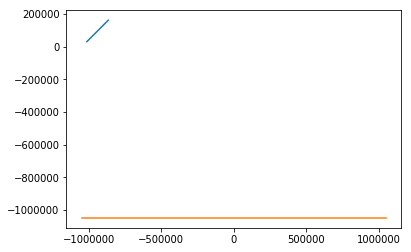

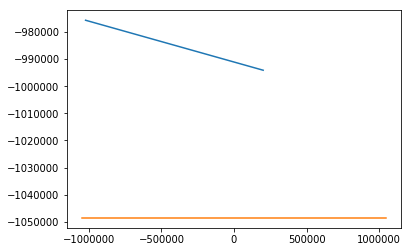

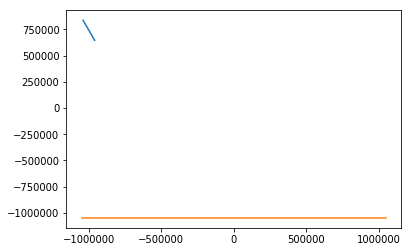

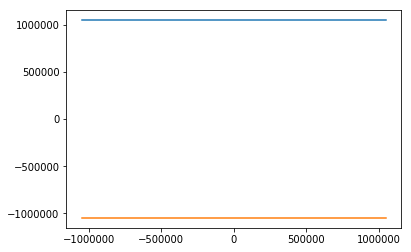

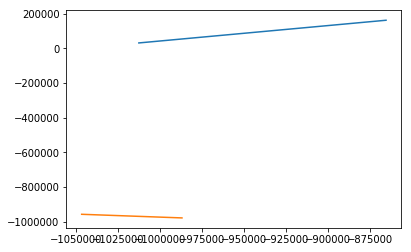

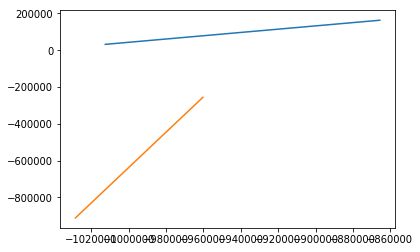

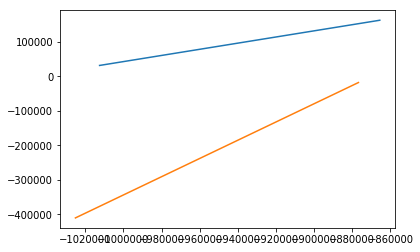

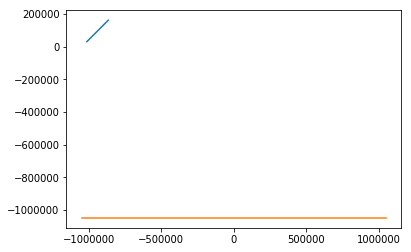

reorder


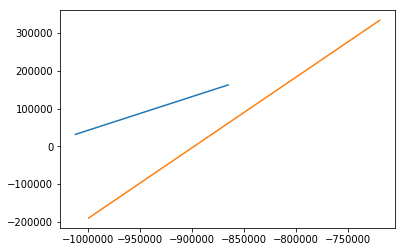

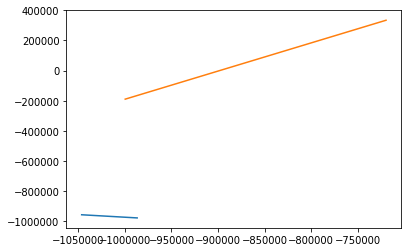

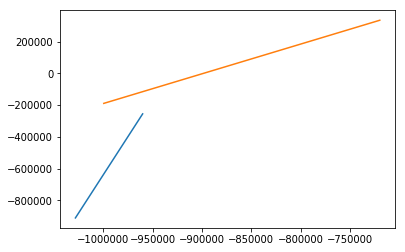

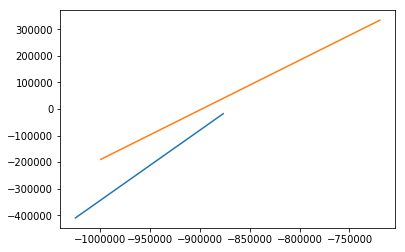

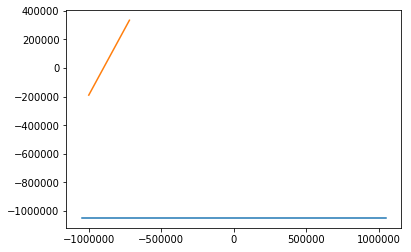

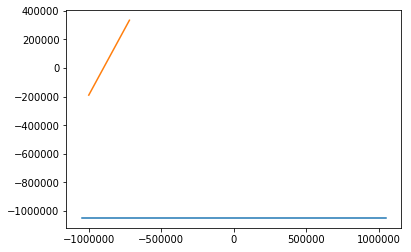

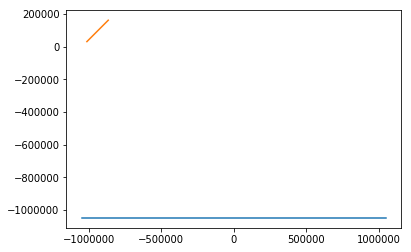

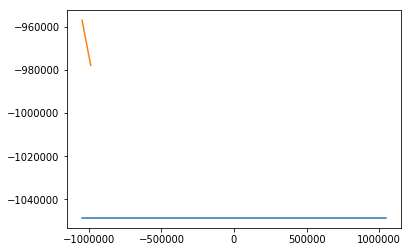

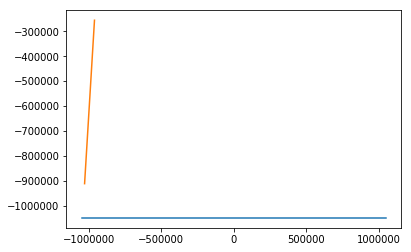

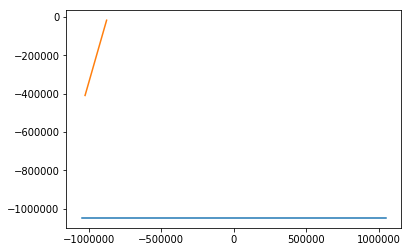

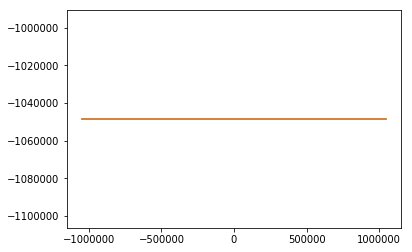

IndexError: list index out of range

In [13]:
findCrossings(newFlags,abSegs)